<a href="https://colab.research.google.com/github/Bonorinoa/math387_final/blob/main/MATH387_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pip installs

In [1]:
# imports
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Modeling VIX states via Markov Regime Switching Regression

This notebook contains three tests:

1. Estimating transition probabilities from data
2. Estimating transition probabilities plus prediction with Markov Regression
3. Estimating transition probabilities plus prediction with Markov Autoregression to account for autocorrelations

## Markov Regression

[*********************100%%**********************]  1 of 1 completed
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2000-01-04  1455.219971  1455.219971  1397.430054  1399.420044  1399.420044   
2000-01-05  1399.420044  1413.270020  1377.680054  1402.109985  1402.109985   
2000-01-06  1402.109985  1411.900024  1392.099976  1403.449951  1403.449951   
2000-01-07  1403.449951  1441.469971  1400.729980  1441.469971  1441.469971   
2000-01-10  1441.469971  1464.359985  1441.469971  1457.599976  1457.599976   

                Volume  Log_Returns  
Date                                 
2000-01-04  1009000000    -0.039099  
2000-01-05  1085500000     0.001920  
2000-01-06  1092300000     0.000955  
2000-01-07  1225200000     0.026730  
2000-01-10  1064800000     0.011128  


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Filtered Probabilities of the Last Observation:
0    0.049812
1    0.939439
2    0.010749
Name: 2022-12-30 00:00:00, dtype: float64

Transition Matrix:
[[[9.76671425e-01]
  [2.39996974e-02]
  [1.34573272e-05]]

 [[2.32774513e-02]
  [9.67376935e-01]
  [4.43092417e-02]]

 [[5.11236461e-05]
  [8.62336739e-03]
  [9.55677301e-01]]]


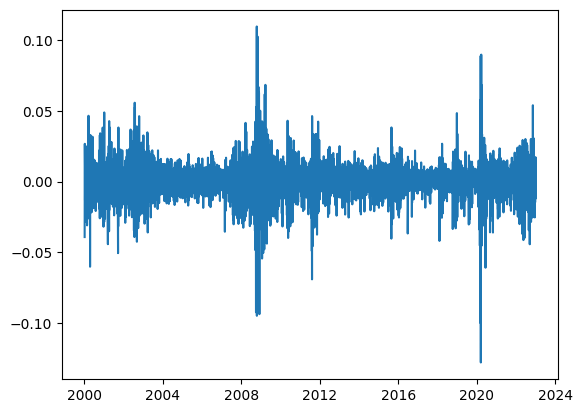

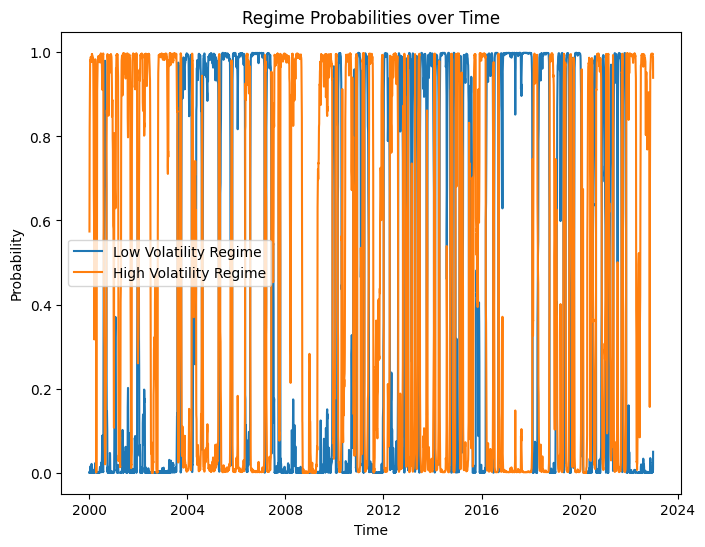

In [9]:
# Gotta switch this to the VIX instead
# time period 2010-01-01 to 2023-01-01

# Fetch S&P 500 historical data
sp500 = yf.download('^GSPC', start='2000-01-01', end='2023-01-01')

# Preprocess data: Calculate log returns
sp500['Log_Returns'] = np.log(sp500['Close'] / sp500['Close'].shift(1))
sp500.dropna(inplace=True)

# Display the first few rows of the processed data
print(sp500.head())

plt.plot(sp500['Log_Returns'])
#plt.show()

# Setting up the Markov Switching Model
model = sm.tsa.MarkovRegression(sp500['Log_Returns'], k_regimes=3, trend='c', switching_variance=True)
results = model.fit()

# Print the summary of the model's results

#print(results.summary())
# Extract regime probabilities
regime_probabilities = results.smoothed_marginal_probabilities

# Plotting
plt.figure(figsize=(8,6))
plt.plot(regime_probabilities[0], label='Low Volatility Regime')
plt.plot(regime_probabilities[1], label='High Volatility Regime')
plt.title('Regime Probabilities over Time')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
#plt.show()

## Predicting state probabilities
# Assuming 'results' is your fitted MarkovSwitching model
filtered_probs = results.filtered_marginal_probabilities.iloc[-1]
transition_matrix = results.regime_transition

print("Filtered Probabilities of the Last Observation:")
print(filtered_probs)
print("\nTransition Matrix:")
print(transition_matrix)

In [10]:
# we use the trnasition matrix and filtered probabilities for prediction
# Reshape the transition matrix from 3D to 2D
reshaped_transition_matrix = transition_matrix.reshape(3, 3)

# Predict the next state probabilities
next_state_probs = np.dot(reshaped_transition_matrix, filtered_probs)

print("Predicted State Probabilities for the Next Period:")
print(next_state_probs)

Predicted State Probabilities for the Next Period:
[0.07119676 0.9104273  0.01837594]


## Markov Autoregression

In [6]:
autoregressive_model = sm.tsa.MarkovAutoregression(sp500['Log_Returns'], k_regimes=3,
                                                   order=1, switching_ar=False)

# Fit the model
fitted_armodel = autoregressive_model.fit()

# Print model summary
print(fitted_armodel.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                         Markov Switching Model Results                         
Dep. Variable:              Log_Returns   No. Observations:                 5785
Model:             MarkovAutoregression   Log Likelihood               17791.556
Date:                  Thu, 23 Nov 2023   AIC                         -35561.111
Time:                          20:01:00   BIC                         -35487.818
Sample:                               0   HQIC                        -35535.612
                                 - 5785                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0354      0.001    -27.212      0.000      -0.038      -0.033
                             Regime 

InvalidIndexError: ignored

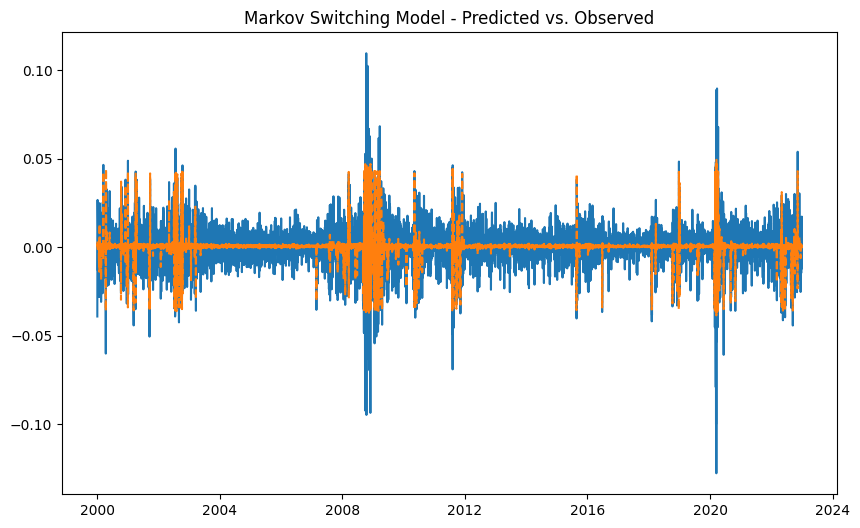

In [7]:
# Predicted values
predicted_values = fitted_armodel.predict()

# Regime probabilities
regime_probs = fitted_armodel.smoothed_marginal_probabilities

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(sp500['Log_Returns'], label='Observed')
plt.plot(predicted_values, label='Predicted', linestyle='dashed')
plt.title('Markov Switching Model - Predicted vs. Observed')

# Adding regime probability plot
plt.fill_between(range(len(regime_probs)), 0, 1, where=regime_probs[:, 0] > 0.5, color='gray', alpha=0.3, label='Regime 1 Probability > 50%')
plt.legend()
plt.show()